In [1]:
from PIL import Image, ImageDraw
import random
import seaborn as sns
import cProfile
import pstats
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

def matrix(string):
    return np.array(list(map(int, string.replace('\xa0','0').split(','))))

class Nonogram:
    def __init__(self, height = 30, width = 30, step_size = 25):
        
        image = Image.new(mode='L', size=(height* step_size, width * step_size), color=255)

        # Draw some lines
        draw = ImageDraw.Draw(image)
        y_start = 0
        y_end = image.height

        for x in range(0, image.width, step_size):
            line = ((x, y_start), (x, y_end))
            draw.line(line, fill=128)

        x_start = 0
        x_end = image.width

        for y in range(0, image.height, step_size):
            line = ((x_start, y), (x_end, y))
            draw.line(line, fill=128)
        
        self.step_size = step_size
        self.imgdraw = ImageDraw.Draw(image)
        self.image = image  
        
    def color(self,i,j):        
        self.imgdraw.rectangle([(i * self.step_size, j * self.step_size),((i + 1) * self.step_size,(j + 1) *self.step_size)], fill = 0)
    

    def draw(self,i,j,text):
        i= (i + 0.4) * self.step_size
        j= (j + 0.3) * self.step_size
        self.imgdraw.text((i,j), text, fill =0)

    def matrixdraw(self,M, start = (0,0)):
        for i, m in enumerate(M):
            for j, v in enumerate(m):
                self.draw(i + start[0],j + start[1],str(v) if v != 0 else '')


class Matrix(Nonogram):
    def __init__(self,data):
        size = (data['sizeCol'],data['sizeRow'])
        c = matrix(data['colClues']).reshape(size[0],-1).T
        r = matrix(data['rowClues']).reshape(-1,size[1]).T
        super().__init__(r.shape[0] + c.shape[0],r.shape[1] + c.shape[1])
        self.matrixdraw(r, start = (c.shape[0],0))
        self.matrixdraw(c, start = (0,r.shape[1]))
        self.emptyshape = (c.shape[0],r.shape[1])
        self.c = c.T
        self.r = r
        self.difficulty = data['difficulty']
        self.shape = (c.shape[1],r.shape[0])
        self.solution = data['solution']
        self.imagecopy = self.image.copy()
        self.R = [{'len':len([c for c in r if c!=0]),
                 'sum': sum(r),
                 'entity':np.array([[c] for c in r if c!=0])} for r in self.r]
        self.C = [{'len':len([c for c in r if c!=0]),
                 'sum': sum(r),
                 'entity':np.array([[c] for c in r if c!=0])} for r in self.c]
        
    def Mdraw(self,M = None):
        if(M is None):
            M = np.zeros(self.shape)
            
        self.image = self.imagecopy.copy()
        self.imgdraw = ImageDraw.Draw(self.image)
        M = M.T
        for i, m in enumerate(M):
            for j, v in enumerate(m):
                if(v):
                    self.color(i + self.emptyshape[0],j + self.emptyshape[1])
        return self.image
                    



In [2]:
def Stats(f):
    profile = cProfile.Profile()
    profile.runcall(f)
    ps = pstats.Stats(profile)
    ps.print_stats()

In [3]:
class AIC:    
#     def sort(self,M):
#         n = np.prod(self.shape)
#         A = np.zeros(n-len(M),dtype = int)
#         for m in M:
#             A = np.insert(A, m,1)
#         return np.flatnonzero(A)

    def sort(self,s):
        s = np.sort(s)
        while True:
          dp = np.flatnonzero(s[1:] == s[:-1])+1
          if(not len(dp)): break        
          s[np.flatnonzero(s[1:] == s[:-1])]-=1 
        return s
    
    def __init__(self, M):
        minim = np.zeros(M.shape,dtype=bool)
        maxim = np.zeros(M.shape,dtype=bool)
        for i,c in enumerate(M.C):
            maxim[i][-c['len']-c['sum']+1:-c['sum']+1] = True
            minim[i][:c['len']] = True
        self.maxim = np.flatnonzero(maxim)
        self.minim = np.flatnonzero(minim)     
        self.M = M
        self.shape = M.shape
                
        mask = np.ones(M.shape,dtype=bool)
        nmask = np.ones(M.shape,dtype=bool)
        for i,c in enumerate(M.C):
            if(1-c['sum']):
             mask[i][-c['sum']+1:] = False
            nmask[i][c['len']:] = False
        self.mask = mask
        self.nmask = nmask     
    
    def generate(self):
        diff = self.maxim - self.minim        
        return self.sort(self.minim + np.round(diff * np.random.rand(*diff.shape)).astype(int))

    def unmaskop(row, arr):
        (iones,) = np.where(row)
        shift = np.roll(arr,1)
        shift[0] = 0
        iones = 2**(iones +np.cumsum(shift) )      
        return AIC.binify(np.sum((2**(arr)-1)*iones),len(row))
    
    def unmask(self,arr):
        M = np.bincount(arr).astype(bool)
        M.resize(self.shape)
        return np.vstack([AIC.unmaskop(m,n[n!=0]) for m,n in zip(M,self.M.c)])

    def boundary(self,M):
        return np.minimum(np.maximum(M,self.minim),self.maxim)
    
    def crossover(self,M1,M2):
        mask = np.random.binomial(p=0.5,n=1,size = M1.shape).astype(bool)        
        return self.sort(M1*mask + M2*(1-mask))          
    

    def mutate(self,A,mrate):
        mask = np.random.binomial(p=mrate,n=1,size = A.shape).astype(bool)
        index = np.flatnonzero(mask)
        even = index[index%2==0]
        odd = index[index%2==1]
        return self.boundary(self.sort(self.hmutate(self.hmutate(A,odd),even)))

    def hmutate(self, A,pivot):
        last = False
        if(len(A)-1 in pivot):
            pivot = pivot[:-1]
            last = True
        maxim = np.minimum(A[pivot+1],self.maxim[pivot])
        minim = np.maximum(A[pivot-1],self.minim[pivot])
        if(0 in pivot):
            minim[0] = 0
        if(last):
            maxim = np.append(maxim,self.maxim[-1])
            minim = np.append(minim,A[-2])
            pivot = np.append(pivot,len(A)-1)

        diff = maxim - minim
        A[pivot] =  minim + np.ceil(diff * np.random.rand(len(diff))).astype(int)
        return A
          
    
    def binify(arr,n):
        return (np.array([*np.binary_repr(arr).zfill(n)]) == '1')[::-1]

class AIR(AIC):
    def __init__(self, M):
        shape = (M.shape[1],M.shape[0])
        minim = np.zeros(shape,dtype=bool)
        maxim = np.zeros(shape,dtype=bool)
        for i,c in enumerate(M.R):
            maxim[i][-c['len']-c['sum']+1:-c['sum']+1] = True
            minim[i][:c['len']] = True
        self.maxim = np.flatnonzero(maxim)
        self.minim = np.flatnonzero(minim)     
        self.M = M
        self.shape = shape      
        
        shape = (M.shape[1],M.shape[0])
        mask = np.ones(shape,dtype=bool)
        nmask = np.ones(shape,dtype=bool)
        for i,c in enumerate(M.R):
            if(1-c['sum']):
             mask[i][-c['sum']+1:] = False
            nmask[i][c['len']:] = False
        self.mask = mask
        self.nmask = nmask      
        self.M = M
        self.shape = M.shape
    
    def unmask(self,arr):
        M = np.bincount(arr).astype(bool)
        M.resize(self.shape)
        return np.vstack([AIC.unmaskop(m,n[n!=0]) for m,n in zip(M,self.M.r)]).T    


In [4]:
def LC(n,k):
    def LF(n):
        return np.sum(np.log(np.arange(1,n+1)))
    """
    logarithm of n choose k
    """
    return LF(n)-LF(k)-LF(n-k)


In [5]:
class Fitness:
    def setup(aic,air):
        C = np.array([LC(n,k) for n,k in zip(np.sum(aic.mask,1),np.sum(aic.nmask,1))])
        R = np.array([LC(n,k) for n,k in zip(np.sum(air.mask,1),np.sum(air.nmask,1))])
        FM = (C.reshape(-1,1) @ R.reshape(1,-1))
        FM[FM == 0] = 1/np.sum(FM)            
        Fitness.matrix = 1/FM
        
    def goal():
        return np.sum(Fitness.matrix)
        
    def fitness(ai):
        return np.sum((~(ai.R ^ ai.C))* Fitness.matrix)    
    
class AI:
    def __init__(self,M,aic,air,C,R):
        self.M = M
        self.aic = aic
        self.air = air
        self._C = C
        self._R = R
        self.goal = Fitness.goal()
        
    @property
    def C(self):
        return self.aic.unmask(self._C)
    
    @property
    def R(self):
        return self.air.unmask(self._R)
    
    @property
    def fitness(self):
        return Fitness.fitness(self)

    def mutate(self, mrate = 0.05):        
        self._C,self._R = self.aic.mutate(self._C,mrate = mrate),self.air.mutate(self._R,mrate = mrate)
        return self
    
    @np.vectorize
    def crossover(self, ai2, mrate = 0.05):        
        C = self.aic.crossover(self._C,ai2._C)
        R = self.air.crossover(self._R,ai2._R)
        C,R = self.aic.mutate(C, mrate = mrate),self.air.mutate(R,mrate = mrate)        
        return AI(self.M,self.aic,self.air,C,R)
    
    def copy(self):
        ai =  AI(self.M,self.aic,self.air)
        ai._C = np.copy(self._C)
        ai._R = np.copy(self._R)
        return ai    
        
        

***goal**** 
29.388346740700616
max fitness:  20.059324845555842 9.329021895144773


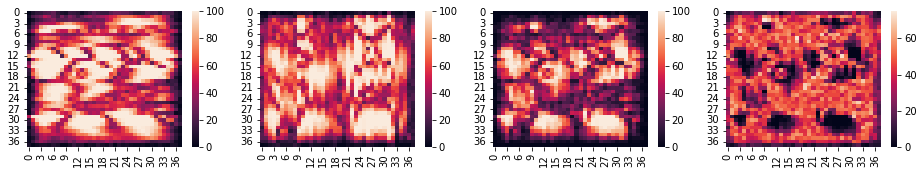

max fitness:  20.20062800001591 9.187718740684705
max fitness:  20.610997775730866 8.77734896496975
max fitness:  20.67056350989872 8.717783230801896
max fitness:  21.027102389130388 8.361244351570228
max fitness:  21.258232537726297 8.130114202974319
max fitness:  21.43969188897934 7.948654851721276
max fitness:  21.483137186860695 7.905209553839921
max fitness:  21.574146084270716 7.8142006564299
max fitness:  21.85052084674927 7.5378258939513465
max fitness:  21.92164289800703 7.466703842693587


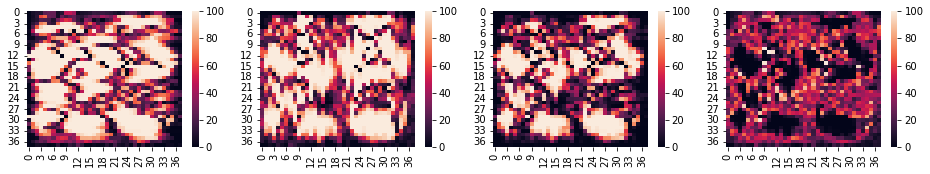

max fitness:  21.969261703344216 7.4190850373564
max fitness:  22.048980953957766 7.3393657867428495
max fitness:  22.193909874550123 7.194436866150493
max fitness:  22.259774510973966 7.12857222972665
max fitness:  22.324908958536653 7.0634377821639625
max fitness:  22.400424730221744 6.987922010478872
max fitness:  22.678460847670152 6.709885893030464
max fitness:  22.678460847670152 6.709885893030464
max fitness:  22.756552178608487 6.631794562092129
max fitness:  22.833645148561928 6.554701592138688


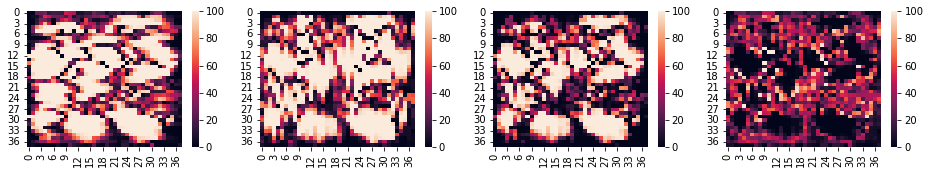

max fitness:  22.860003798719774 6.528342941980842
max fitness:  22.973725801786294 6.414620938914322
max fitness:  23.026950945184197 6.361395795516419
max fitness:  23.088305279478803 6.300041461221813
max fitness:  23.231401736285548 6.156945004415068
max fitness:  23.42092628711428 5.967420453586335
max fitness:  23.42092628711428 5.967420453586335
max fitness:  23.42092628711428 5.967420453586335
max fitness:  23.478425645172457 5.9099210955281585
max fitness:  23.540612565476728 5.847734175223888


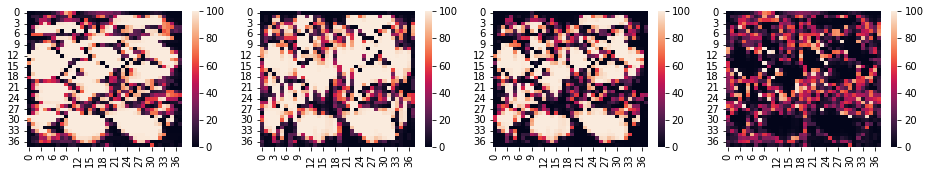

max fitness:  23.62493473388545 5.763412006815166
max fitness:  23.716386629895 5.6719601108056175
max fitness:  23.716386629895 5.6719601108056175
max fitness:  23.716386629895 5.6719601108056175
max fitness:  23.771733487605516 5.6166132530951
max fitness:  23.833352301119902 5.554994439580714
max fitness:  23.853100826402276 5.53524591429834
max fitness:  23.98989961890144 5.398447121799176
max fitness:  23.99618268794722 5.392164052753397
max fitness:  23.99618268794722 5.392164052753397


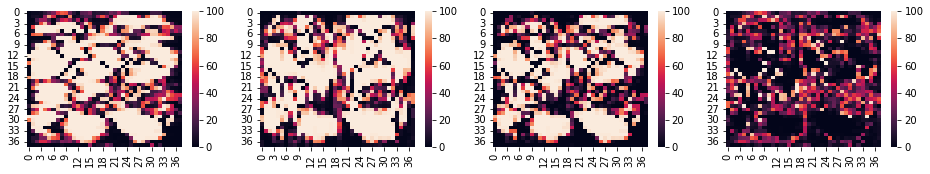

max fitness:  24.013970603529565 5.374376137171051
max fitness:  24.013970603529565 5.374376137171051
max fitness:  24.14630351444155 5.242043226259067
max fitness:  24.194346008293188 5.194000732407428
max fitness:  24.194346008293188 5.194000732407428
max fitness:  24.194346008293188 5.194000732407428
max fitness:  24.308292731327406 5.08005400937321
max fitness:  24.308292731327406 5.08005400937321
max fitness:  24.339344942578023 5.0490017981225925
max fitness:  24.339344942578023 5.0490017981225925


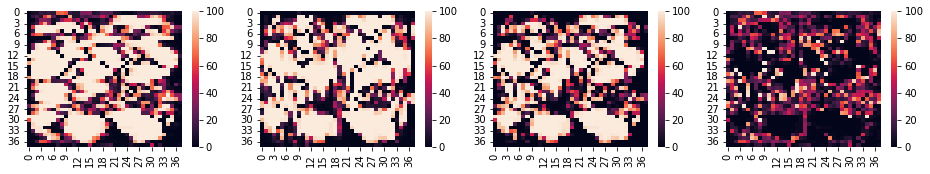

max fitness:  24.339344942578023 5.0490017981225925
max fitness:  24.405497087311495 4.9828496533891204
max fitness:  24.405497087311495 4.9828496533891204
max fitness:  24.405497087311495 4.9828496533891204
max fitness:  24.49119227217657 4.897154468524047
max fitness:  24.586585199060142 4.801761541640474
max fitness:  24.586585199060142 4.801761541640474
max fitness:  24.586585199060142 4.801761541640474
max fitness:  24.586585199060142 4.801761541640474
max fitness:  24.76254215254263 4.625804588157987


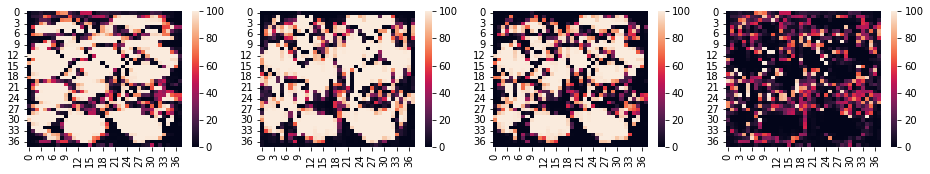

max fitness:  24.76254215254263 4.625804588157987
max fitness:  24.76254215254263 4.625804588157987
max fitness:  24.76254215254263 4.625804588157987
max fitness:  24.76254215254263 4.625804588157987
max fitness:  24.76254215254263 4.625804588157987
max fitness:  24.76254215254263 4.625804588157987
max fitness:  24.76254215254263 4.625804588157987
max fitness:  24.76254215254263 4.625804588157987
max fitness:  24.76254215254263 4.625804588157987
max fitness:  24.76254215254263 4.625804588157987


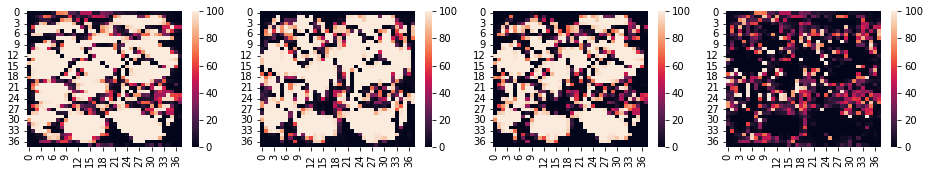

max fitness:  24.830799850352037 4.557546890348579
max fitness:  24.830799850352037 4.557546890348579
max fitness:  24.830799850352037 4.557546890348579
max fitness:  24.830799850352037 4.557546890348579
max fitness:  25.02634393811865 4.362002802581966
max fitness:  25.02634393811865 4.362002802581966
max fitness:  25.02634393811865 4.362002802581966
max fitness:  25.02634393811865 4.362002802581966
max fitness:  25.02634393811865 4.362002802581966
max fitness:  25.02634393811865 4.362002802581966


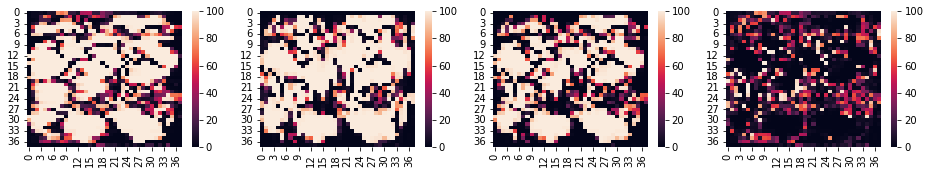

max fitness:  25.02634393811865 4.362002802581966
max fitness:  25.02634393811865 4.362002802581966
max fitness:  25.02634393811865 4.362002802581966
max fitness:  25.02634393811865 4.362002802581966
max fitness:  25.02634393811865 4.362002802581966
max fitness:  25.02634393811865 4.362002802581966
max fitness:  25.02634393811865 4.362002802581966
max fitness:  25.02634393811865 4.362002802581966
max fitness:  25.02634393811865 4.362002802581966
max fitness:  25.077369303251196 4.31097743744942


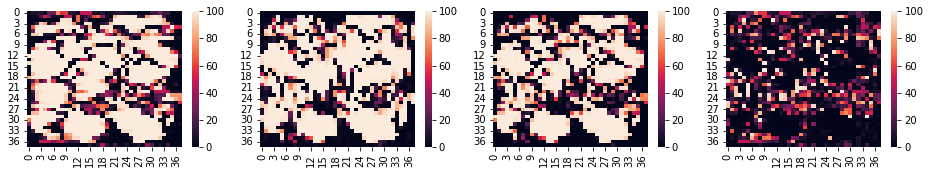

max fitness:  25.077369303251196 4.31097743744942
max fitness:  25.077369303251196 4.31097743744942
max fitness:  25.077369303251196 4.31097743744942
max fitness:  25.077369303251196 4.31097743744942
max fitness:  25.077369303251196 4.31097743744942
max fitness:  25.077369303251196 4.31097743744942
max fitness:  25.094960138826035 4.29338660187458
max fitness:  25.094960138826035 4.29338660187458
max fitness:  25.094960138826035 4.29338660187458
max fitness:  25.118593924227994 4.2697528164726215


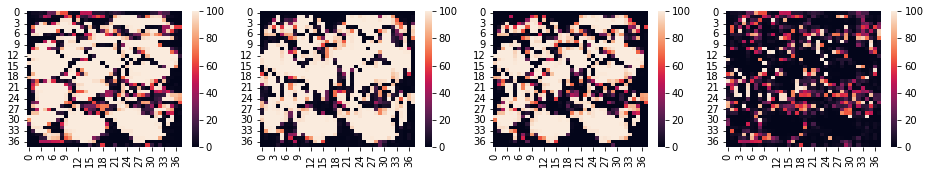

max fitness:  25.118593924227994 4.2697528164726215
max fitness:  25.118593924227994 4.2697528164726215
max fitness:  25.118593924227994 4.2697528164726215
max fitness:  25.189601795930535 4.19874494477008
max fitness:  25.189601795930535 4.19874494477008
max fitness:  25.189601795930535 4.19874494477008
max fitness:  25.189601795930535 4.19874494477008
max fitness:  25.189601795930535 4.19874494477008
max fitness:  25.20069928081481 4.187647459885806
max fitness:  25.20069928081481 4.187647459885806


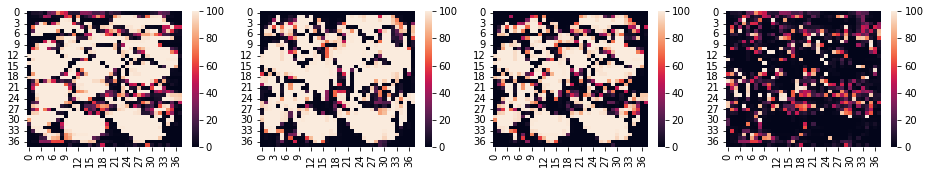

max fitness:  25.20069928081481 4.187647459885806
max fitness:  25.20069928081481 4.187647459885806
max fitness:  25.232417375168332 4.155929365532284
max fitness:  25.232417375168332 4.155929365532284
max fitness:  25.232417375168332 4.155929365532284
max fitness:  25.232417375168332 4.155929365532284
max fitness:  25.232417375168332 4.155929365532284
max fitness:  25.232417375168332 4.155929365532284
max fitness:  25.232417375168332 4.155929365532284
max fitness:  25.232417375168332 4.155929365532284


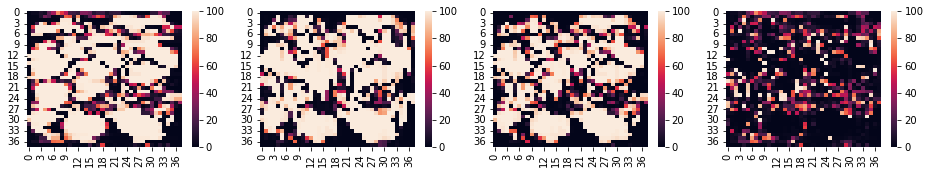

max fitness:  25.232417375168332 4.155929365532284
max fitness:  25.232417375168332 4.155929365532284
max fitness:  25.232417375168332 4.155929365532284
max fitness:  25.27314777362499 4.115198967075624
max fitness:  25.27314777362499 4.115198967075624
max fitness:  25.27314777362499 4.115198967075624
max fitness:  25.27314777362499 4.115198967075624
max fitness:  25.27314777362499 4.115198967075624
max fitness:  25.27314777362499 4.115198967075624
max fitness:  25.27314777362499 4.115198967075624


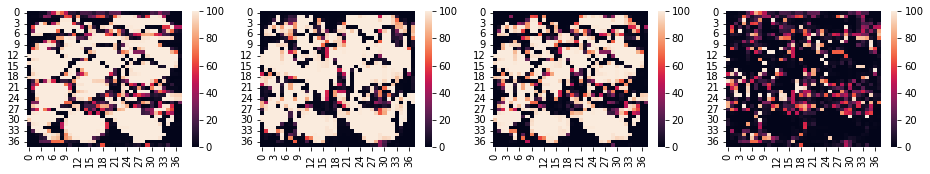

max fitness:  25.27475652898579 4.1135902117148255
max fitness:  25.27475652898579 4.1135902117148255
max fitness:  25.27475652898579 4.1135902117148255
max fitness:  25.27475652898579 4.1135902117148255
max fitness:  25.27475652898579 4.1135902117148255
max fitness:  25.320811097736783 4.067535642963833
max fitness:  25.320811097736783 4.067535642963833
max fitness:  25.320811097736783 4.067535642963833
max fitness:  25.320811097736783 4.067535642963833
max fitness:  25.320811097736783 4.067535642963833


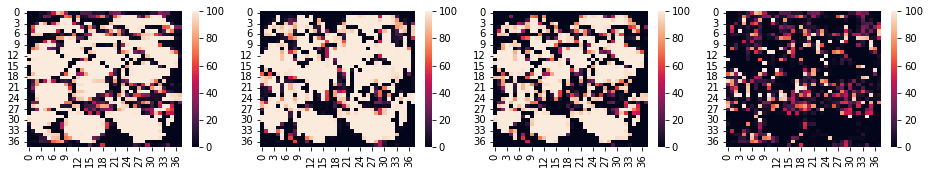

max fitness:  25.36167804392273 4.026668696777886
max fitness:  25.36167804392273 4.026668696777886
max fitness:  25.36167804392273 4.026668696777886
max fitness:  25.36167804392273 4.026668696777886
max fitness:  25.36497007610667 4.023376664593947
max fitness:  25.36497007610667 4.023376664593947
max fitness:  25.36497007610667 4.023376664593947
max fitness:  25.36497007610667 4.023376664593947
max fitness:  25.36497007610667 4.023376664593947
max fitness:  25.36497007610667 4.023376664593947


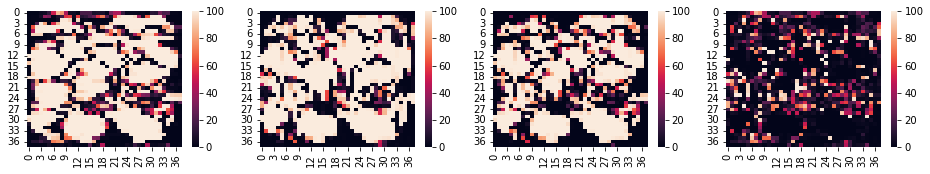

max fitness:  25.397670084572 3.990676656128617
max fitness:  25.397670084572 3.990676656128617
max fitness:  25.397670084572 3.990676656128617
max fitness:  25.397670084572 3.990676656128617
max fitness:  25.397670084572 3.990676656128617
max fitness:  25.397670084572 3.990676656128617
max fitness:  25.397670084572 3.990676656128617
max fitness:  25.397670084572 3.990676656128617
max fitness:  25.397670084572 3.990676656128617
max fitness:  25.397670084572 3.990676656128617


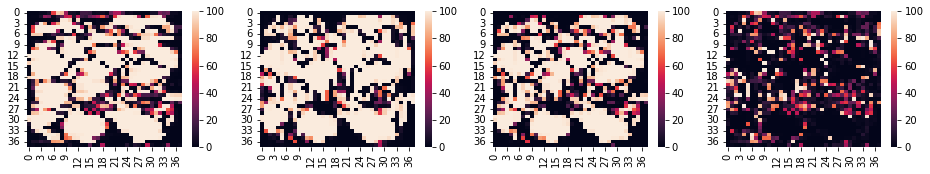

max fitness:  25.444331178110097 3.9440155625905184
max fitness:  25.444331178110097 3.9440155625905184
max fitness:  25.444331178110097 3.9440155625905184
max fitness:  25.444331178110097 3.9440155625905184
max fitness:  25.480840013581684 3.907506727118932
max fitness:  25.480840013581684 3.907506727118932
max fitness:  25.480840013581684 3.907506727118932
max fitness:  25.480840013581684 3.907506727118932
max fitness:  25.480840013581684 3.907506727118932
max fitness:  25.480840013581684 3.907506727118932


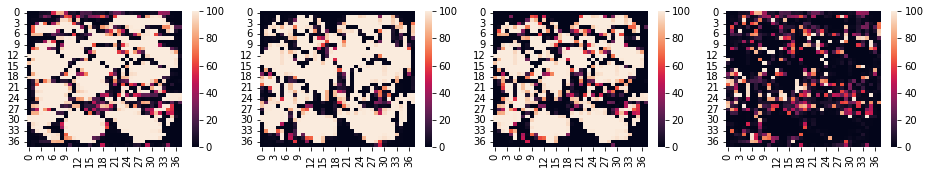

max fitness:  25.480840013581684 3.907506727118932
max fitness:  25.480840013581684 3.907506727118932
max fitness:  25.480840013581684 3.907506727118932
max fitness:  25.480840013581684 3.907506727118932
max fitness:  25.480840013581684 3.907506727118932
max fitness:  25.519541090575146 3.86880565012547
max fitness:  25.519541090575146 3.86880565012547
max fitness:  25.519541090575146 3.86880565012547
max fitness:  25.519541090575146 3.86880565012547
max fitness:  25.55054339469102 3.837803346009597


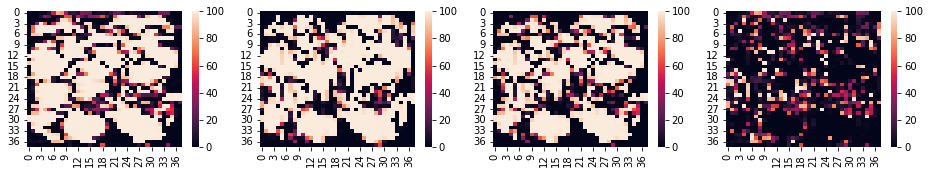

max fitness:  25.55054339469102 3.837803346009597
max fitness:  25.55054339469102 3.837803346009597
max fitness:  25.55054339469102 3.837803346009597
max fitness:  25.55054339469102 3.837803346009597
max fitness:  25.55054339469102 3.837803346009597
max fitness:  25.55054339469102 3.837803346009597
max fitness:  25.55054339469102 3.837803346009597
max fitness:  25.55054339469102 3.837803346009597
max fitness:  25.55054339469102 3.837803346009597
max fitness:  25.55054339469102 3.837803346009597


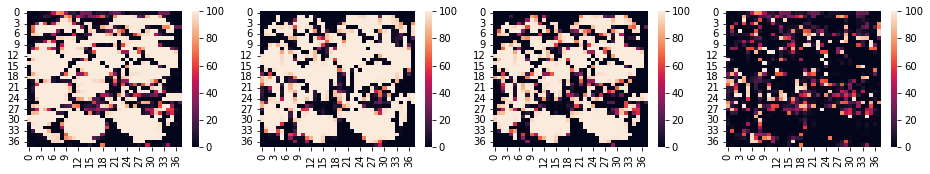

max fitness:  25.55054339469102 3.837803346009597
max fitness:  25.55128590797262 3.837060832727996
max fitness:  25.55128590797262 3.837060832727996
max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.65229000885636 3.736056731844254


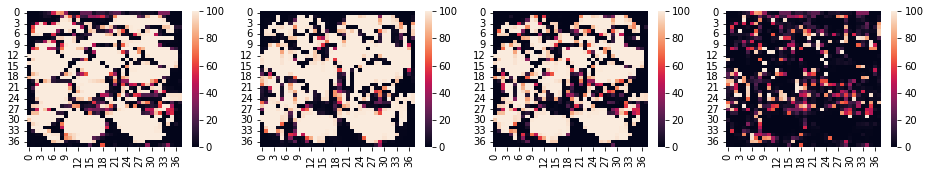

max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.65229000885636 3.736056731844254


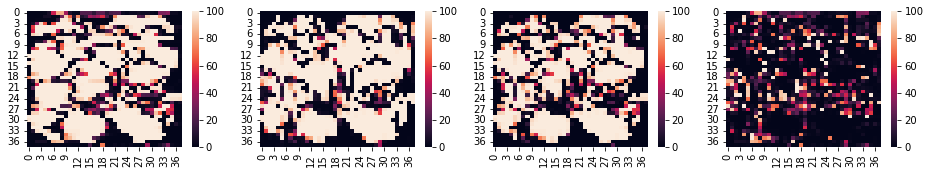

max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.65229000885636 3.736056731844254
max fitness:  25.617610853105788 3.770735887594828
max fitness:  25.617610853105788 3.770735887594828
max fitness:  25.617610853105788 3.770735887594828
max fitness:  25.617610853105788 3.770735887594828
max fitness:  25.62475383538306 3.763592905317555
max fitness:  25.62475383538306 3.763592905317555
max fitness:  25.62475383538306 3.763592905317555


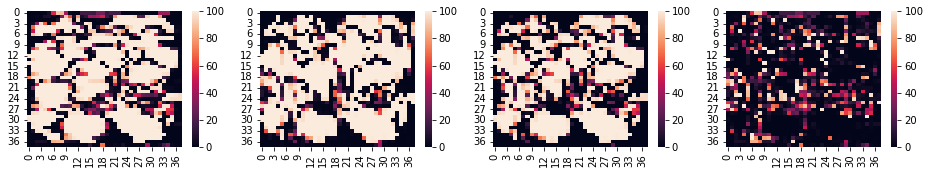

max fitness:  25.640627072794043 3.7477196679065727
max fitness:  25.640627072794043 3.7477196679065727
max fitness:  25.640627072794043 3.7477196679065727
max fitness:  25.653893437765394 3.734453302935222
max fitness:  25.653893437765394 3.734453302935222
max fitness:  25.653893437765394 3.734453302935222
max fitness:  25.653893437765394 3.734453302935222
max fitness:  25.653893437765394 3.734453302935222
max fitness:  25.653893437765394 3.734453302935222
max fitness:  25.690057511924046 3.69828922877657


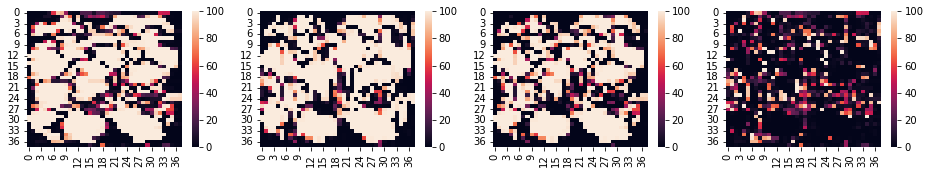

max fitness:  25.690057511924046 3.69828922877657
max fitness:  25.690057511924046 3.69828922877657
max fitness:  25.690057511924046 3.69828922877657
max fitness:  25.690057511924046 3.69828922877657
max fitness:  25.690057511924046 3.69828922877657
max fitness:  25.690057511924046 3.69828922877657
max fitness:  25.690057511924046 3.69828922877657
max fitness:  25.690057511924046 3.69828922877657
max fitness:  25.690057511924046 3.69828922877657
max fitness:  25.690057511924046 3.69828922877657


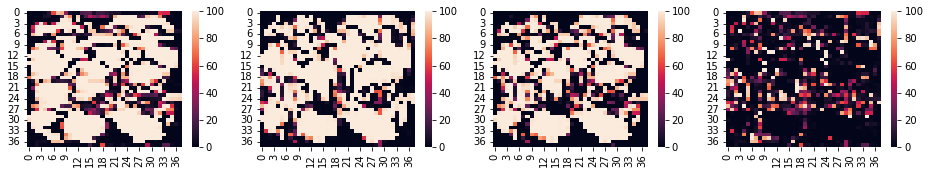

max fitness:  25.690057511924046 3.69828922877657
max fitness:  25.690057511924046 3.69828922877657
max fitness:  25.690057511924046 3.69828922877657
max fitness:  25.65702582293449 3.7313209177661264
max fitness:  25.65702582293449 3.7313209177661264
max fitness:  25.65702582293449 3.7313209177661264
max fitness:  25.65702582293449 3.7313209177661264
max fitness:  25.65702582293449 3.7313209177661264
max fitness:  25.65702582293449 3.7313209177661264
max fitness:  25.65702582293449 3.7313209177661264


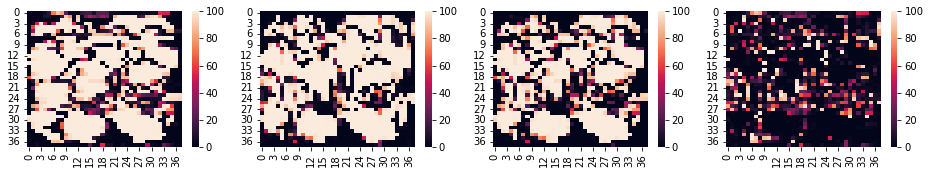

max fitness:  25.65702582293449 3.7313209177661264
max fitness:  25.65702582293449 3.7313209177661264
max fitness:  25.65702582293449 3.7313209177661264
max fitness:  25.65702582293449 3.7313209177661264
max fitness:  25.670694541614466 3.7176521990861495
max fitness:  25.670694541614466 3.7176521990861495
max fitness:  25.670694541614466 3.7176521990861495
max fitness:  25.670694541614466 3.7176521990861495
max fitness:  25.670694541614466 3.7176521990861495
max fitness:  25.68025405378241 3.7080926869182065


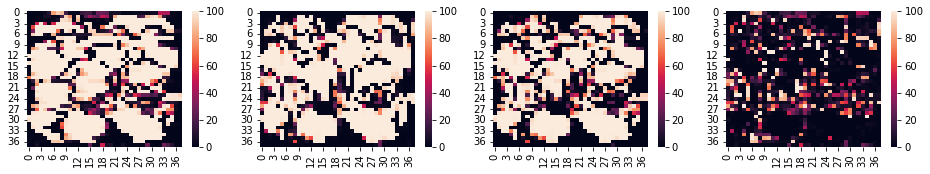

max fitness:  25.68025405378241 3.7080926869182065
max fitness:  25.68025405378241 3.7080926869182065
max fitness:  25.68025405378241 3.7080926869182065
max fitness:  25.68025405378241 3.7080926869182065
max fitness:  25.68025405378241 3.7080926869182065
max fitness:  25.68025405378241 3.7080926869182065
max fitness:  25.68025405378241 3.7080926869182065
max fitness:  25.68025405378241 3.7080926869182065
max fitness:  25.68025405378241 3.7080926869182065
max fitness:  25.824203345864074 3.5641433948365417


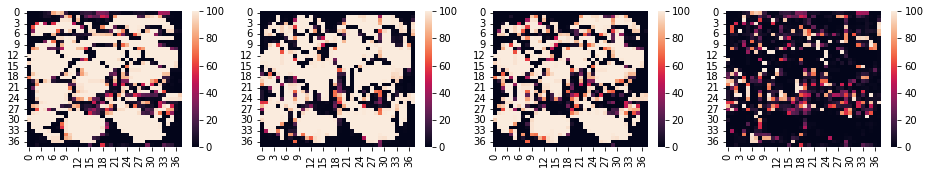

max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417


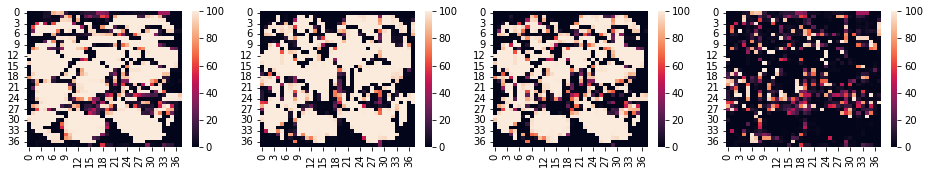

max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417


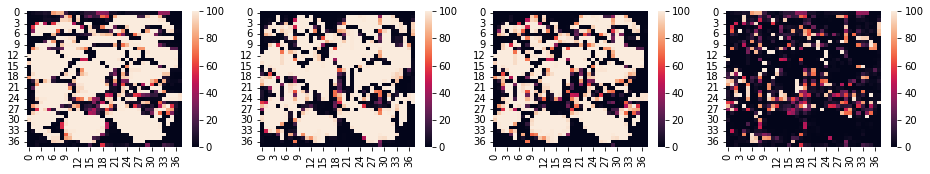

max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.824203345864074 3.5641433948365417
max fitness:  25.80853177982673 3.579814960873886
max fitness:  25.80853177982673 3.579814960873886
max fitness:  25.80853177982673 3.579814960873886
max fitness:  25.80853177982673 3.579814960873886


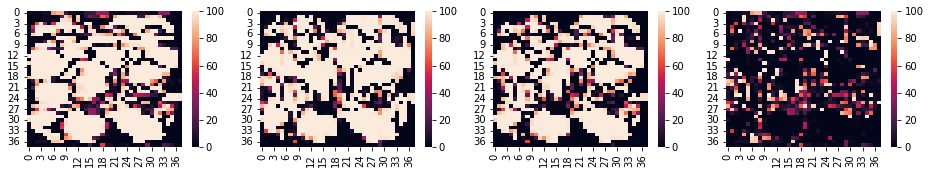

max fitness:  25.80853177982673 3.579814960873886
max fitness:  25.80853177982673 3.579814960873886
max fitness:  25.80853177982673 3.579814960873886
max fitness:  25.80853177982673 3.579814960873886
max fitness:  25.80853177982673 3.579814960873886
max fitness:  25.80853177982673 3.579814960873886
max fitness:  25.80853177982673 3.579814960873886
max fitness:  25.80853177982673 3.579814960873886
max fitness:  25.813967265172163 3.5743794755284526
max fitness:  25.813967265172163 3.5743794755284526


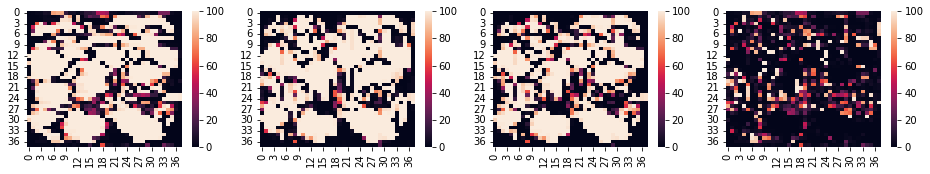

max fitness:  25.813967265172163 3.5743794755284526
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483


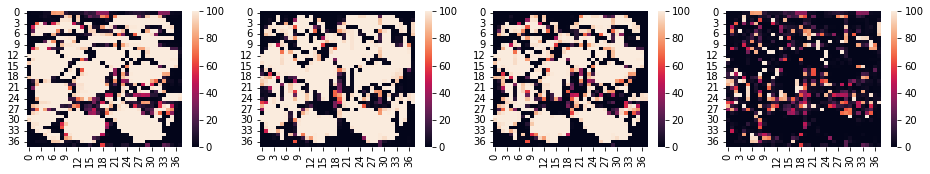

max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483


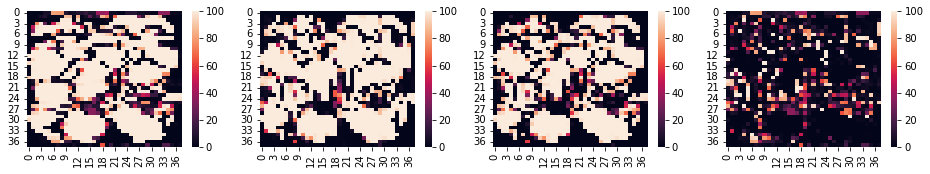

max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483


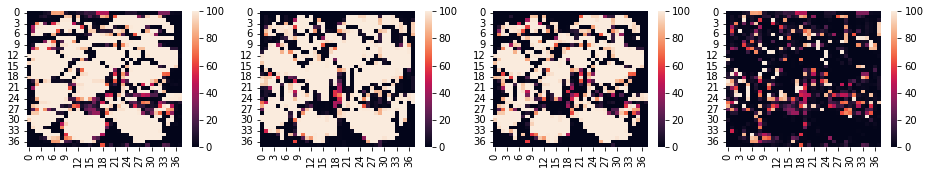

max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.829914054739668 3.5584326859609483
max fitness:  25.833673536078063 3.554673204622553


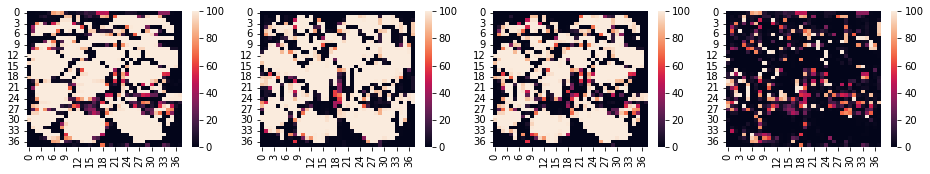

max fitness:  25.833673536078063 3.554673204622553
max fitness:  25.833673536078063 3.554673204622553
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344


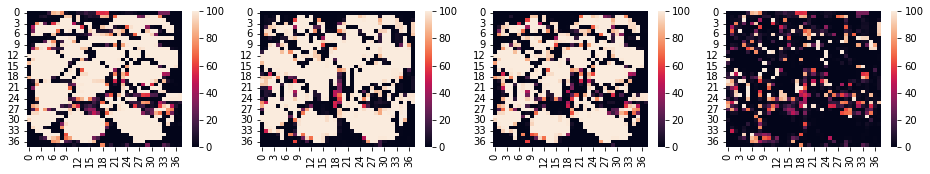

max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344


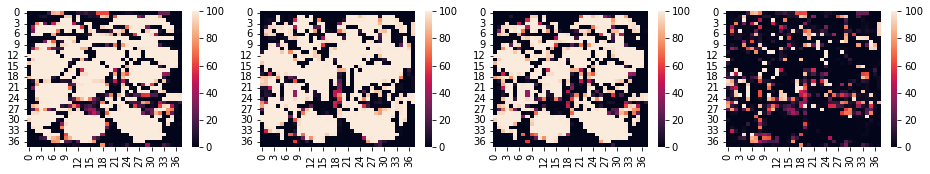

max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.83545162215758 3.5528951185430344
max fitness:  25.846602554574172 3.5417441861264436
max fitness:  25.851695244924453 3.5366514957761623
max fitness:  25.851695244924453 3.5366514957761623
max fitness:  25.906970494855116 3.4813762458454995


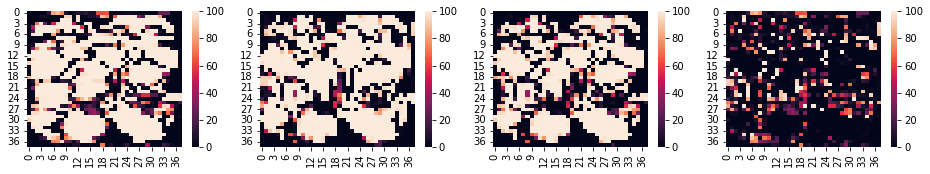

max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995


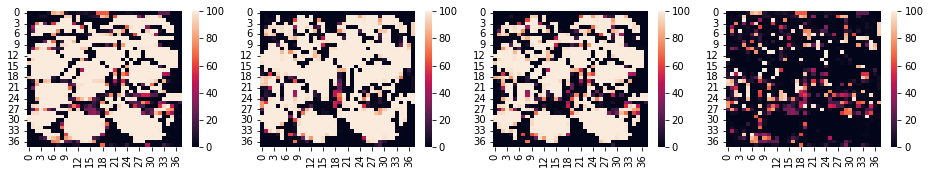

max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995


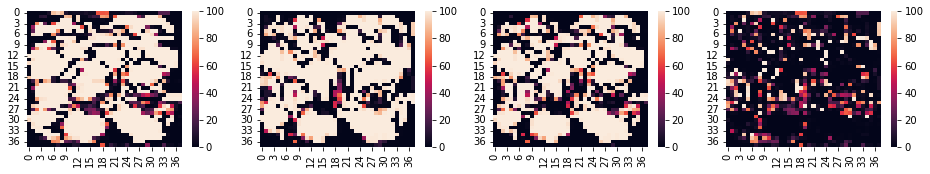

max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.906970494855116 3.4813762458454995
max fitness:  25.851695244924453 3.5366514957761623
max fitness:  25.86788137159406 3.5204653691065566
max fitness:  25.86788137159406 3.5204653691065566
max fitness:  25.86788137159406 3.5204653691065566
max fitness:  25.86788137159406 3.5204653691065566


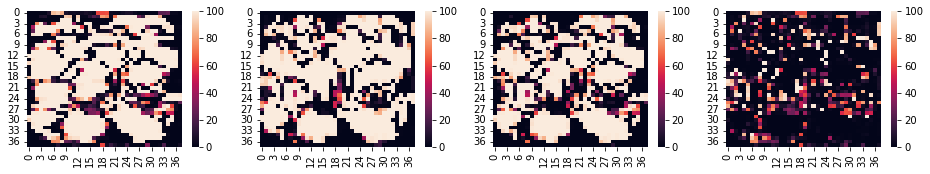

max fitness:  25.86788137159406 3.5204653691065566
max fitness:  25.86788137159406 3.5204653691065566
max fitness:  25.86788137159406 3.5204653691065566
max fitness:  25.86788137159406 3.5204653691065566
max fitness:  25.86788137159406 3.5204653691065566
max fitness:  25.86788137159406 3.5204653691065566
max fitness:  25.86788137159406 3.5204653691065566
max fitness:  25.86788137159406 3.5204653691065566
max fitness:  25.86788137159406 3.5204653691065566
max fitness:  25.86788137159406 3.5204653691065566


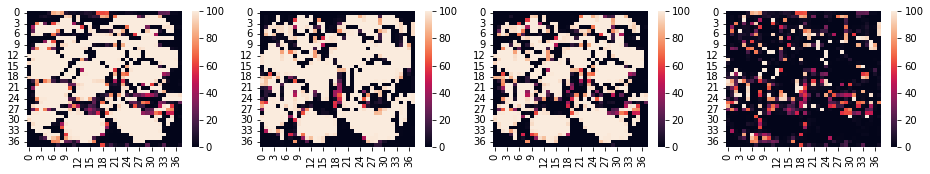

max fitness:  25.86788137159406 3.5204653691065566
max fitness:  25.86788137159406 3.5204653691065566
max fitness:  25.930330161837617 3.458016578862999
max fitness:  25.930330161837617 3.458016578862999
max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494


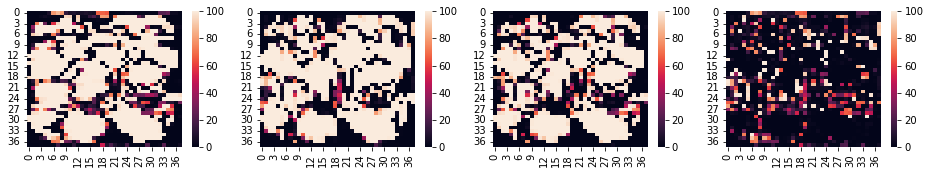

max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494


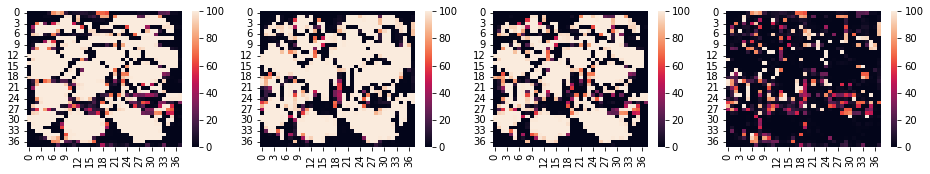

max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.950616217836966 3.4377305228636494
max fitness:  25.930330161837617 3.458016578862999
max fitness:  25.930330161837617 3.458016578862999
max fitness:  25.930330161837617 3.458016578862999
max fitness:  25.930330161837617 3.458016578862999
max fitness:  25.930330161837617 3.458016578862999


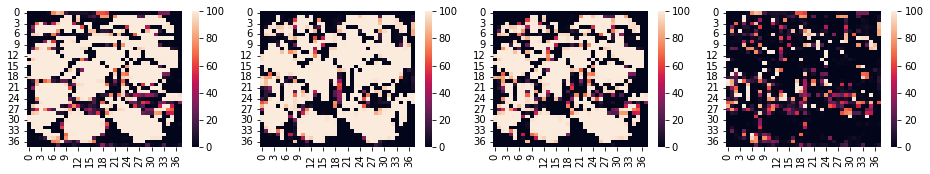

max fitness:  25.930330161837617 3.458016578862999
max fitness:  25.930330161837617 3.458016578862999
max fitness:  25.930330161837617 3.458016578862999
max fitness:  25.930330161837617 3.458016578862999
max fitness:  25.930330161837617 3.458016578862999
max fitness:  25.930330161837617 3.458016578862999
max fitness:  25.930330161837617 3.458016578862999
max fitness:  25.930330161837617 3.458016578862999
max fitness:  25.930330161837617 3.458016578862999


KeyboardInterrupt: 

In [6]:
df = pd.read_csv('nonogram.csv')
M = Matrix(df.iloc[300])
M.solution,M.difficulty
aic = AIC(M)
air = AIR(M)
Fitness.setup(aic,air)

nai = 100
nchildren = 1000
niteration = 10000
nshuffle = 10
mrate = 0.05

ais = np.array([AI(M,aic,air,aic.generate(),air.generate()) for _ in range(nai)])
goal = ais[0].goal
print('***goal**** ')
print(goal)


for n in range(niteration):
    
    S1, S2 = np.vstack([np.random.choice(ais,2,replace=False) for _ in range(nchildren)]).T    
    ais = np.append(ais,AI.crossover(S1, S2,mrate = mrate))

    for _ in range(nshuffle):
        s1,s2 = np.random.choice(ais,2,replace=False)
        s1._C, s2._C = s2._C, s1._C        
            
    
    fitness = list(map(lambda x: x.fitness,ais))
    ais = ais[np.argsort(fitness)[::-1][:nai]]
    print('max fitness: ',np.max(fitness), goal - np.max(fitness))
    
    
    
    if(not n%10):
        fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize = (16,2.5))
        sns.heatmap(np.sum(np.array([ai.C for ai in ais]),0),ax = ax1)
        sns.heatmap(np.sum(np.array([ai.R for ai in ais]),0),ax = ax2)
        sns.heatmap(np.sum(np.array([ai.C & ai.R for ai in ais]),0),ax = ax3)
        sns.heatmap(np.sum(np.array([ai.C ^ ai.R for ai in ais]),0),ax = ax4)
        plt.show()


In [7]:
M.solution

'http://static.nonograms.org/files/nonograms/large/fialki10_12_1_1p.png'